# Optimización de hiperparámetros

Hay dos métodos comunes de ajuste de parámetros: *grid search* y *random search*. Cada uno tiene sus pros y sus contras. El *grid search* es lento pero efectivo para buscar en todo el espacio de búsqueda, mientras que el *ramdom search* es rápido, pero podría pasar por alto puntos importantes en el espacio de búsqueda. Afortunadamente, existe una tercera opción: La **optimización bayesiana**. Nos centraremos en una implementación de la optimización Bayesiana, con la librería **hyperopt**.

El uso de la optimización bayesiana para la optimización de parámetros nos permite obtener los mejores parámetros para un modelo determinado, por ejemplo, la regresión logística. Típicamente, un científico de datos realizará algún tipo de ajuste manual de parámetros (*grid search* o *random search*) para unos pocos modelos - como el árbol de decisión, la máquina de vector soporte y los k vecinos más cercanos - y elegirá el que minimice la métrica de evaluación seleccionada. Mediante este método existe la posibilidad de comparar modelos subóptimos. Tal vez el científico de datos encontró los parámetros óptimos para el árbol de decisión, pero no encontró los parámetros óptimos para el SVM. Esto significa que la comparativa de modelos es inapropiada. El k-NN pueden vencer al SVM cada vez si los parámetros del SVM están mal ajustados. La optimización bayesiana permite al científico de datos encontrar los mejores parámetros para todos los modelos, y por lo tanto comparar los mejores modelos. Esto da como resultado una mejor selección de modelos, porque está comparando el mejor k-NN con el mejor árbol de decisión. Sólo de esta manera se puede hacer una selección de modelos con alta confianza, asegurándose de que el mejor modelo real sea seleccionado y utilizado.


La librería escogida utiliza como algoritmo básico de optimización "Tree-structured Parzen Estimator" (TPE). El TPE es un aproximación secuencial de optimizacion basada en modelos (SMBO). Los métodos SMBO construyen secuencialmente modelos para aproximar el rendimiento de una seleccion de hiperparámetros basándose 
en resultados historicos y así escoger nuevos hiperparametros que se comprueban con el modelo. Particularmente, TPE modela dos distribuciones $P(x|y)$ y $P(y)$ donde $x$ representa los hiperparametros e $y$ el rendimiento asociado, y optimiza la mejora esperada (expected improvement, EI) siguiendo la ecuacion:
$$
EI_y^∗(x) = \int_{\inf}^{y^*}(y^* − y) \frac{P(x|y)P(y)}{P(x)} dx 
$$

Teniendo en cuenta el Teorema de Bayes:

$$
\int_{\inf}^{y^*}(y^* − y) P(y|x) dx
$$

donde $y^∗$ es algún cuantil $γ$ de los valores observados y tal que $p(y < y^∗) = γ$.

Las librerias necesarias son **hyperopt**, **pymongo** y **lightgbm**.

## Funciones Objetivo

Supongamos una función definida en algún rango, y que se debe minimizar. Es decir, se quiere encontrar el valor de entrada que resulte en el valor de salida más bajo. El ejemplo trivial que se presenta a continuación encuentra el valor de $x$ que minimiza una función lineal $y(x) = x$.

In [1]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=lambda x: x,
    space=hp.uniform('x', 0, 1),
    algo=tpe.suggest,
    max_evals=1000)

100%|██████████| 1000/1000 [00:04<00:00, 248.81trial/s, best loss: 5.955110870456106e-06]


Desglosemos paso a paso.

La función **fmin** primero toma una función para minimizar, denotada **fn**, que aquí especificamos con una función anónima **lambda x: x**. Esta función podría ser cualquier función válida de retorno de valorque devuelva un valor, como el error absoluto medio en la regresión.

El siguiente parámetro especifica el espacio de búsqueda, y en este ejemplo es el rango continuo de números entre 0 y 1, especificado por hp.uniform('x', 0, 1). **hp.uniform** es una hiperfunción incorporada que toma tres parámetros: el nombre, x, y los límites inferior y superior del rango, 0 y 1.

Mediante el parámetro **algo** se define el algoritmo de búsqueda, en este caso **tpe** que significa "Tree Parzen Estimators ". Si se fija como **hiperopt.random**, realiza un **random search**.

Por último, especificamos el número máximo de evaluaciones **max_evals** que realiza la función **fmin**.

El resultado se almacena en un diccionario de python, en el caso anterior el resultado es: 

In [2]:
print(best)

{'x': 5.955110870456106e-06}


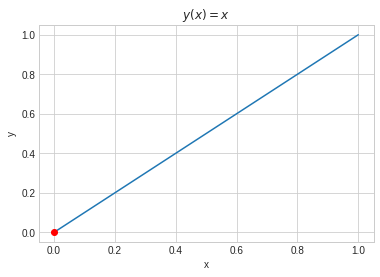

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

x = np.linspace(0, 1, 10)
ax = plt.axes()
ax.set(xlabel='x', ylabel='y',
       title='$y(x) = x$')
plt.plot(x, x , linestyle='solid')
plt.plot(best['x'],best['x'], 'ro');

### Algunos ejemplos más complicados

Esta vez estamos tratando de minimizar una ecuación cuadrática $y(x) = (x-1)^2$. Así que alteramos el espacio de búsqueda para incluir lo que sabemos que es el valor óptimo $(x=1)$ más algunos rangos subóptimos a cada lado: **hp.uniforme('x', -2, 2)**.

100%|██████████| 100/100 [00:00<00:00, 548.82trial/s, best loss: 4.274398662332377e-05]


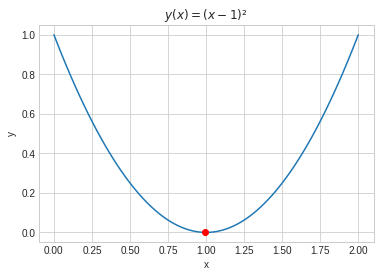

In [4]:
fn = lambda x: (x-1)**2
x = np.linspace(0, 2, 100)
best = fmin(
    fn=fn,
    space=hp.uniform('x', -2, 2),
    algo=tpe.suggest,
    max_evals=100)
ax = plt.axes()
ax.set(xlabel='x', ylabel='y',
       title='$y(x) = (x-1)²$')
plt.plot(x, fn(x) , linestyle='solid')
plt.plot(best['x'],fn(best['x']), 'ro');

En lugar de minimizar una función objetivo, tal vez queramos maximizarla. Para ello sólo tenemos que devolver el negativo de la función. Por ejemplo, podríamos tener una función $y(x) = -(x^2)$

100%|██████████| 100/100 [00:00<00:00, 551.48trial/s, best loss: 2.38608156379919e-08]


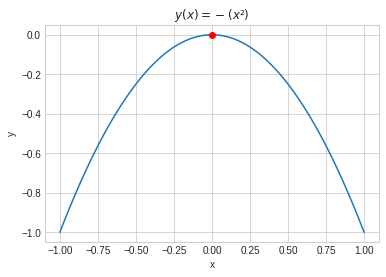

In [5]:
fn = lambda x: (x)**2
x = np.linspace(-1, 1, 100)
fn_neg = lambda x: -(x)**2


best = fmin(
    fn=fn,
    space=hp.uniform('x', -1, 1),
    algo=tpe.suggest,
    max_evals=100)

ax = plt.axes()
ax.set(xlabel='x', ylabel='y',
       title='$y(x) = -(x²)$')
plt.plot(x, fn_neg(x) , linestyle='solid')
plt.plot(best['x'],fn_neg(best['x']), 'ro');

He aquí una función con muchos (infinitamente muchos dado un rango infinito) mínimos locales, que también estamos tratando de maximizar:

100%|██████████| 100/100 [00:00<00:00, 556.35trial/s, best loss: -0.9999999479148034]


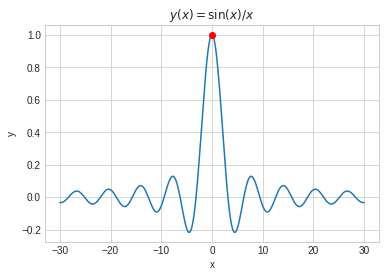

In [6]:
fn = lambda x: -np.sin(x)/x
x = np.linspace(-30, 30, 1000)
fn_neg = lambda x: np.sin(x)/x


best = fmin(
    fn=fn,
    space=hp.uniform('x', -1, 1),
    algo=tpe.suggest,
    max_evals=100)

ax = plt.axes()
ax.set(xlabel='x', ylabel='y',
       title='$y(x) = \sin(x)/x$')
plt.plot(x, fn_neg(x) , linestyle='solid')
plt.plot(best['x'],fn_neg(best['x']), 'ro');

## Espacios de búsqueda

La librería **hyperopt** incluye algunas funciones para especificar los rangos de los parámetros de entrada además del **hp.uniform**. Inicialmente, son espacios de búsqueda estocásticos, pero a medida que **hyperopt** aprende más (ya que obtiene más retroalimentación de la función objetivo), adapta y muestrea diferentes partes del espacio de búsqueda inicial que cree que le darán la información más significativa.

Las más habituales son:

    1. hp.choice(label, options): donde las opciones deben ser una lista de python o tupla.
    2. hp.normal(label, mu, sigma):  donde mu y sigma son la media y la desviación estándar, respectivamente.
    3. hp.uniform(label, low, high): donde low y high son los límites inferior y superior del rango.
    
Existen otras, como hp.lognormal o hp.quniform.

Para ver algún ejemplo de los espacios de búsqueda, debemos importar otra función, y definir el espacio de búsqueda. Si se ejecuta repetidamente obtenemos distintos puntos del espacio definido.

In [7]:
import hyperopt.pyll.stochastic
for i in range(10):
    space = {
        'x': hp.uniform('x', 0, 1),
        'y': hp.normal('y', 0, 1),
        'name': hp.choice('name', ['alice', 'bob']),
    }
    print(hyperopt.pyll.stochastic.sample(space))

{'name': 'bob', 'x': 0.35890700401892617, 'y': -1.2457418450412294}
{'name': 'bob', 'x': 0.10547509063441662, 'y': -0.9785103024258822}
{'name': 'bob', 'x': 0.9295567338128328, 'y': 0.2653358041978768}
{'name': 'bob', 'x': 0.08675680778202077, 'y': -1.1011310645359924}
{'name': 'bob', 'x': 0.4238654850733343, 'y': 1.2293667087764406}
{'name': 'bob', 'x': 0.9366492684817457, 'y': 1.7468232394595327}
{'name': 'bob', 'x': 0.933571399127957, 'y': 0.9242296988473196}
{'name': 'bob', 'x': 0.009093588078958326, 'y': 0.3033890916446776}
{'name': 'alice', 'x': 0.6113100224686089, 'y': -0.815704993932792}
{'name': 'alice', 'x': 0.6881129955058909, 'y': 0.5565482006767686}


## Capturar información mediante experimentos

Convendría ver exactamente lo que ocurre dentro de esta caja negra de optimización. El objeto **Trials** nos permite hacer justamente eso. Para ello importamos alguna funcionalidad extra.

El objeto **Trials** nos permite almacenar información en cada paso. Podemos entonces imprimirlas y ver cuáles fueron las evaluaciones de la función para un parámetro dado en un tiempo determinado.

In [8]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, atpe
fspace = {
    'x': hp.uniform('x', -5, 5)
}
def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': STATUS_OK}
trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=1000, trials=trials)
print('best:{}\n'.format(best))
print('trials:\n')
for trial in trials.trials[:2]:
    print(trial,'\n')

100%|██████████| 1000/1000 [00:03<00:00, 311.22trial/s, best loss: 1.1216147236085054e-06]
best:{'x': 0.0010590631348548138}

trials:

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 1.2512128523205017, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [1.1185762612895473]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 3, 11, 19, 2, 33, 335000), 'refresh_time': datetime.datetime(2020, 3, 11, 19, 2, 33, 335000)} 

{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 10.250429638158261, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [1]}, 'vals': {'x': [3.201629216220745]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 3, 11, 19, 2, 33, 336000), 'refresh_time': datetime.datetime(2020, 3, 11, 19, 2, 33, 336000)} 



El objeto de prueba almacena datos como un objeto BSON, que funciona igual que un objeto JSON. BSON es de la librería **pymongo**. No discutiremos los detalles, pero hay opciones avanzadas de **hyperopt** que requieren computación distribuida usando MongoDB, de ahí la importación de **pymongo**.

Volviendo a los resultados anteriores. El "tid" es el id de tiempo, es decir, el paso de tiempo, que va de 0 a max_evals-1. Aumenta en uno cada iteración. "x" está en la clave "vals", que es donde se almacenan los parámetros de cada iteración. "loss" está en la clave "result", que nos da el valor de nuestra función objetivo en esa iteración.

Otra manera de analizar estos resultados es de manera visual. A través de dos gráficos podemos analizar los resultados obtenidos: val vs. time, and loss vs. val.

Veamos primero, val vs. time.

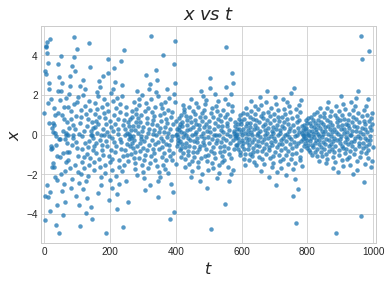

In [9]:
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['x'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16);

Podemos ver que inicialmente el algoritmo recoge valores de todo el rango de forma igual (uniforme), pero a medida que pasa el tiempo y se aprende más sobre el efecto del parámetro en la función objetivo, el algoritmo se centra cada vez más en las áreas en las que cree que ganará más: el rango cercano a cero. Sigue explorando todo el espacio de la solución, pero con menos frecuencia.

Ahora veamos la gráfica de la loss vs val.

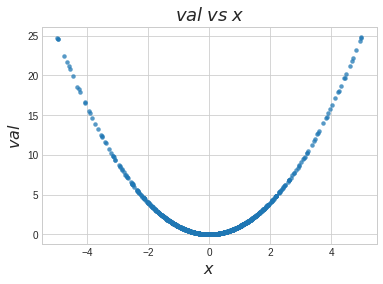

In [10]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16);

Esto nos da lo que esperamos, ya que la función $y(x) = x^2$ es determinista.

## Ejemplo: Iris

En esta sección, veremos 4 ejemplos completos de uso del **hyperopt** para la optimización de parámetros en un conjunto de datos clásico, el Iris. Utilizaremos k-NN, SVM, Árboles de Decisión y Ranom Forest. Intentaremos maximizar la precisión de la validación cruzada, o lo que es lo mismo minimizar el error, ya que **hyperopt** sólo sabe cómo minimizar una función. Minimizar una función $f$ es lo mismo que maximizar el negativo de $f$.

Para esta tarea, usaremos el clásico conjunto de datos Iris, y haremos un aprendizaje supervisado. Hay 4 características de entrada, y tres clases de salida. Los datos están etiquetados como pertenecientes a la clase 0, 1, o 2, que se asignan a diferentes tipos de flor de Iris. La entrada tiene 4 columnas: longitud del sépalo, anchura del sépalo, longitud del pétalo y anchura del pedal. Las unidades de la entrada son centímetros. Usaremos estas 4 características para entrenar un modelo que predice una de las tres clases de salida. Como los datos son proporcionados por **sklearn**, tiene un bonito atributo DESCR que proporciona detalles sobre el conjunto de datos. 

In [11]:
from sklearn import datasets
iris = datasets.load_iris()
print(iris.feature_names) # input names
print(iris.target_names) # output names
print(iris.DESCR) # everything else

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high

Conozcamos un poco mejor los datos a través de la visualización de las características y las clases.

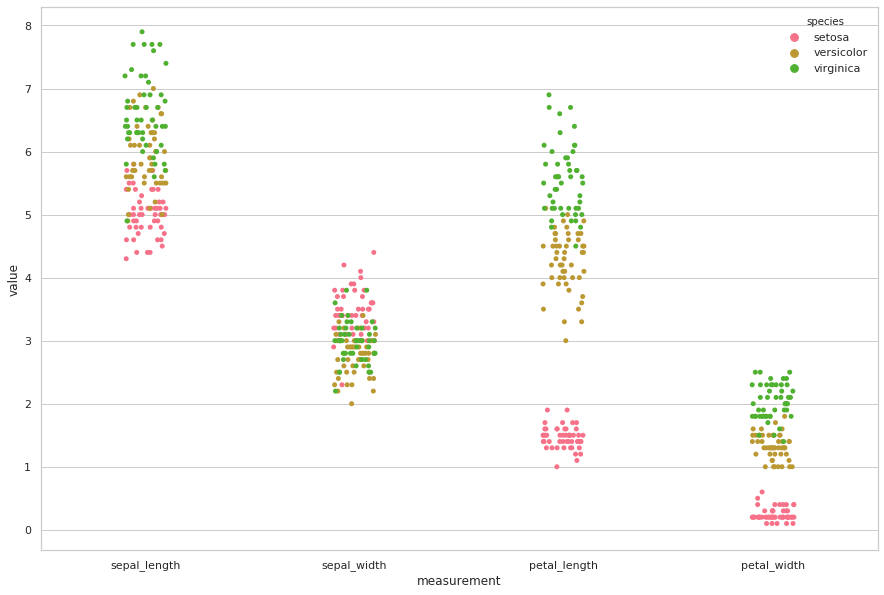

In [12]:
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="husl")
iris = sns.load_dataset("iris")

# Long format to plot
iris = pd.melt(iris, "species", var_name="measurement")

f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax);

### k-NN

Ahora aplicamos la busqueda bayesiana para encontrar el mejor número de vecinos para el kNN.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import random
import numpy as np
np.random.seed(1234)
random.seed(1234)
iris = datasets.load_iris()
X = iris.data
y = iris.target
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return round(cross_val_score(clf, X, y, cv=5).mean(),4)
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=atpe.suggest, max_evals=100, trials=trials)
print ('best:{}'.format(best))

100%|██████████| 100/100 [00:08<00:00, 10.71trial/s, best loss: -0.98]
best:{'n_neighbors': 5}


Veamos ahora la evolución de los experimentos para la selección del k optimo.

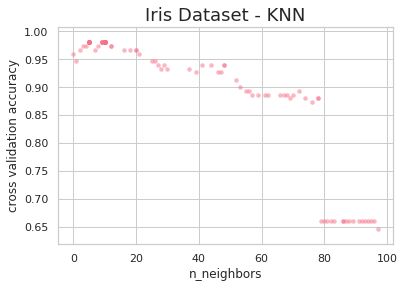

In [14]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12);

Si k es superior a 79, la precisión cae bruscamente. Esto se debe al número de cada clase en el conjunto de datos. Sólo hay 50 casos de cada una de las tres clases. Así que vamos a desglosar limitando los valores de k a valores más pequeños.

In [15]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return round(cross_val_score(clf, X, y, cv=5).mean(),4)
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,20))
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=atpe.suggest, max_evals=100, trials=trials)
print('best:{}'.format(best))

100%|██████████| 100/100 [00:08<00:00, 10.72trial/s, best loss: -0.98]
best:{'n_neighbors': 9}


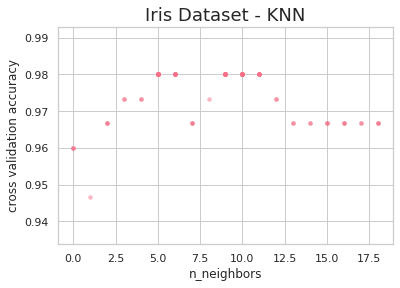

In [16]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12);

Ahora podemos ver claramente que hay un mejor valor para k, en k = 5. En el modelo anterior no hay preprocesado, probemos si escalando o normalizando los datos mejora el resultado.

In [17]:
# now with scaling as an option
from sklearn.preprocessing import normalize, scale
iris = datasets.load_iris()
X = iris.data
y = iris.target
def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = KNeighborsClassifier(**params)
    return round(cross_val_score(clf, X_, y).mean(),4)
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,20)),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=atpe.suggest, max_evals=100, trials=trials)
print('best:{}'.format(best))

100%|██████████| 100/100 [00:10<00:00,  8.53trial/s, best loss: -0.98]
best:{'n_neighbors': 3, 'normalize': 1, 'scale': 0}


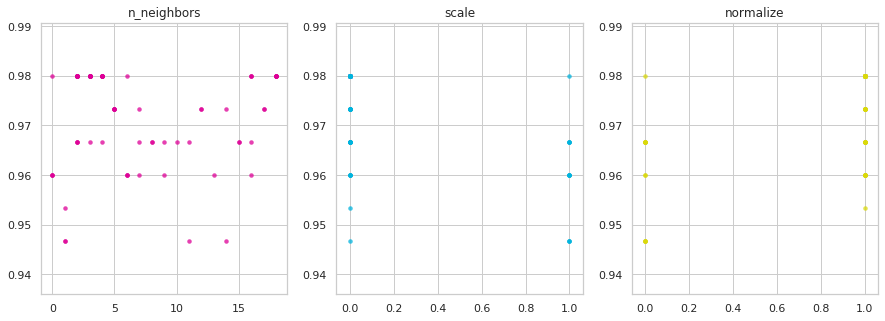

In [18]:
my_colors = ['#DE0097', '#00B4DE', '#DAD90B', '#0F0BDA', '#DA0B1B', '#EDF312']

parameters = ['n_neighbors', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=my_colors[i])
    axes[i].set_title(val)

Vemos que escalar y/o normalizar los datos no mejora la precisión de la predicción.

Vamos a ver gráficamente una aproximación de la superficie de decisión que genera kNN, definido con los parámetros obtenidos. Para ello calculamos la descomposición en componentes principales. Visualizamos así la superficie en dos dimensiones.

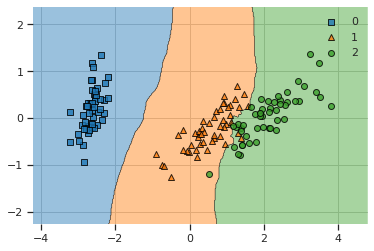

In [19]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(principalComponents,y)

plot_decision_regions(X=principalComponents, y=y, clf=clf);

### SVM

100%|██████████| 100/100 [00:12<00:00,  7.70trial/s, best loss: -0.9933]
best:{'C': 3.0046158326316164, 'gamma': 1.4616906657151572, 'kernel': 3, 'normalize': 1, 'scale': 1}


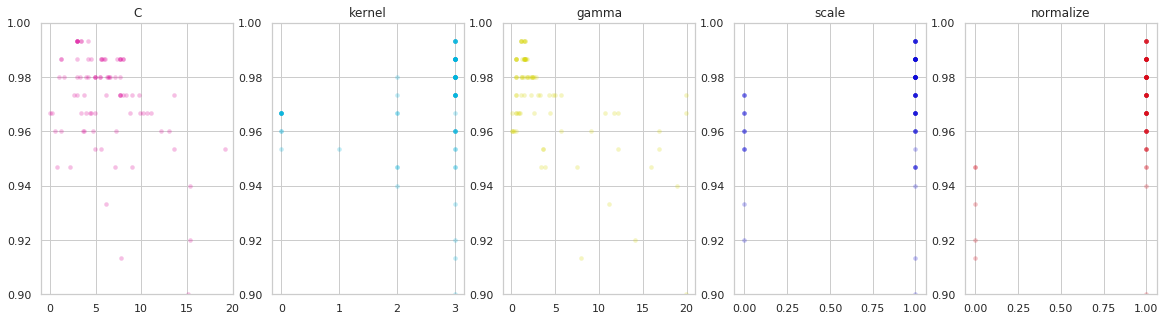

In [20]:
from sklearn.svm import SVC

iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = SVC(**params)
    return round(cross_val_score(clf, X_, y).mean(),4)

space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4svm, algo=atpe.suggest, max_evals=100, trials=trials)
print('best:{}'.format(best))
parameters = ['C', 'kernel', 'gamma', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c=my_colors[i])
    axes[i].set_title(val)
    axes[i].set_ylim([0.9, 1.0])

El mejor kernel es un 'rbf', con C de 8, un 'gamma' de 1.43 y normalizar y escalar los datos.

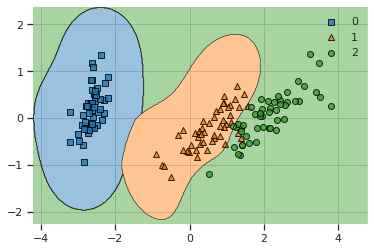

In [21]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

clf = SVC(C=3, kernel='rbf',gamma=1.46, shrinking=False)
clf.fit(principalComponents,y)

plot_decision_regions(X=principalComponents, y=y, clf=clf);

## Árboles de decisión

Sólo intentaremos optimizar algunos parámetros de los árboles de decisión.

In [28]:
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target
def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = DecisionTreeClassifier(**params)
    return round(cross_val_score(clf, X, y).mean(),4)

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=atpe.suggest, max_evals=100, trials=trials)
print('best:{}'.format(best))

100%|██████████| 100/100 [00:11<00:00,  7.51trial/s, best loss: -0.9733]
best:{'criterion': 0, 'max_depth': 3, 'max_features': 2, 'normalize': 1, 'scale': 1}


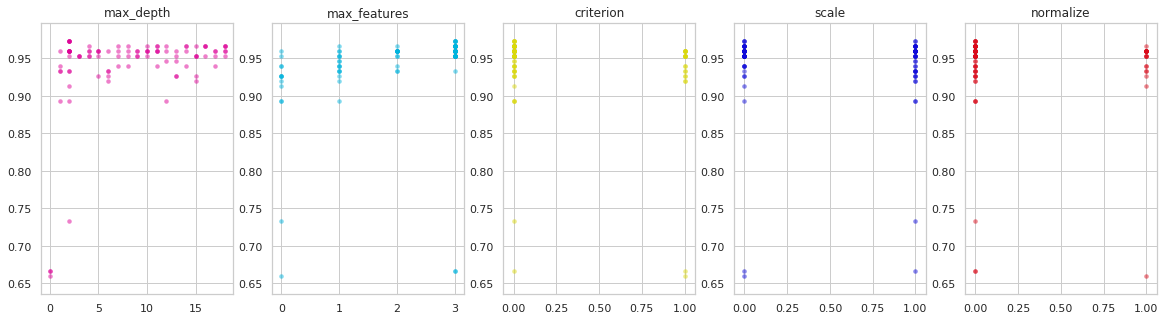

In [23]:
parameters = ['max_depth', 'max_features', 'criterion', 'scale', 'normalize'] # decision tree
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=my_colors[i])
    axes[i].set_title(val)

Representamos la superficie de decisión aproximada para el árbol que genera una precisión del 97.3%.

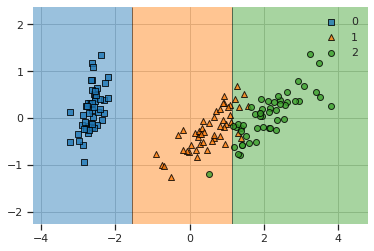

In [29]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

clf = DecisionTreeClassifier(criterion='gini', max_depth=3, max_features=2)
clf.fit(principalComponents,y)

plot_decision_regions(X=principalComponents, y=y, clf=clf);

## Random Forest

Veamos qué sucede con un *ensemble* de árboles, Random Forest.

In [32]:
from sklearn.ensemble import RandomForestClassifier

iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = RandomForestClassifier(**params)
    return round(cross_val_score(clf, X, y).mean(),4)

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=100, trials=trials)
print(('best{}').format(best))

100%|██████████| 100/100 [00:05<00:00, 17.59trial/s, best loss: -0.9733]
best{'criterion': 0, 'max_depth': 3, 'max_features': 0, 'n_estimators': 16, 'normalize': 1, 'scale': 0}


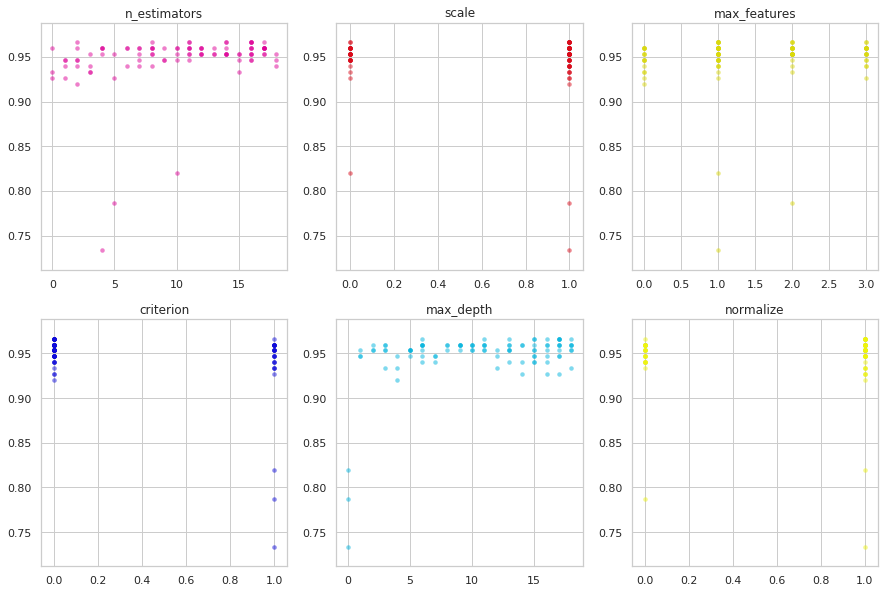

In [26]:
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i%2, i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=my_colors[i])
    axes[i%2, i%3].set_title(val)

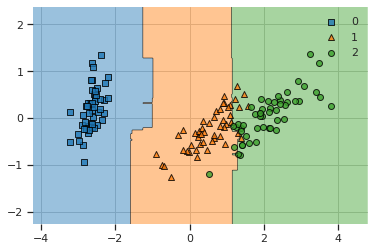

In [33]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

clf = RandomForestClassifier(**{'criterion': 'gini', 'max_depth': 3,  'n_estimators': 16})

clf.fit(principalComponents,y)

plot_decision_regions(X=principalComponents, y=y, clf=clf);

Vemos que los resultados son similares al arbol de decisión, como ya sabemos por la naturaleza del dataset.